# Statistical Analysis of Graphs Generated From LDS Operators

First, we'll characterize the asymmetry of the ``A`` operator estimated over interictal periods. Distributionally and first-order statistics.

Second, we'll formulate some assumptions we can make about these time-varying linear operators and run graspologic functions

In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections
from pprint import pprint
from natsort import natsorted
import sys

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import dabest

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

sys.path.append('../../')
from sickkids.bids.utils import get_resected_chs
_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [22]:
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot
from graspologic.inference import latent_position_test, latent_distribution_test

import matplotlib

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def load_concat_derivs(deriv_path, subject, session, desc, tasks=None):
    # get all the subject/sessions in the derivative path
    subjects = get_entity_vals(deriv_path, 'subject')
    ignore_subjects = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
    ignore_sessions = [ses for ses in sessions if ses != session]

    # store all derivatives found in a list
    derivs = []
    onsets = []
    descriptions = []
    prevlen = 0
    
    if session == 'extraoperative':
        tasks = ['interictal', 'ictal']
        
    if tasks is None:
        # get all the tasks associated if not passed in
        tasks = get_entity_vals(deriv_path, 'task', 
                            ignore_subjects=ignore_subjects,
                            ignore_sessions=ignore_sessions
                           )
    for task in tasks:
        # get all file paths for this subject
        search_str = f'*ses-{session}*task-{task}*desc-{desc}*.json'
        deriv_fpaths = natsorted(list((deriv_path / f'sub-{subject}').glob(search_str)))

#         print(f'Found {len(deriv_fpaths)} derivative file paths')

        for idx, deriv_fpath in enumerate(deriv_fpaths):
            deriv = read_derivative_npy(deriv_fpath, preload=True, 
                                        verbose=False)

            if 'ch_axis' not in deriv.info:
                deriv.info['ch_axis'] = [0]
                rowderiv.info['ch_axis'] = [0 ]

            # create derivative structure
            onsets.append(prevlen + len(deriv))
            descriptions.append(f'ses-{session}-task-{task}-run-{idx+1}')
            prevlen += len(deriv)
    #         if derivative is None:
    #             derivative = deriv.copy()
    #             derivs.append(deriv.copy())
    #         else:
                # check that all channel names are ordered
    #                 if derivative.ch_names != deriv.ch_names:
    #                     deriv.reorder_channels(derivative.ch_names)
    #                     rowderiv.reorder_channels(derivative.ch_names)
    #                 assert derivative.ch_names == deriv.ch_names
    #                 derivative.append(deriv.copy())
            derivs.append(deriv.copy())
    return derivs, onsets, descriptions

## Load Data

In [7]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
sampling_res = '1000Hz'  # 'originalsampling'
deriv_chain = Path(sampling_res) / 'radius1.25' / 'fragility' / reference
deriv_path = deriv_root / deriv_chain

figures_path = deriv_root / 'figures'

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'
rowdesc = 'rowperturbmatrix'

In [38]:
subjects = get_entity_vals(deriv_path, 'subject')

subject = 'E3'
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)

print(f'Sessions in the deriv path {sessions}')
sessions = ['extraoperative', 'preresection', 'intraresection', 'postresection']
print(sessions)

Sessions in the deriv path ['extraoperative', 'postresection', 'preresection']
['extraoperative', 'preresection', 'intraresection', 'postresection']


In [39]:
featurename = 'Col Fragility'
# featurename = 'Row Fragility'
# featurename = 'Absolute Fragility'

# cbarlabel = 'Absolute Diff Fragility'
cbarlabel = 'Col Fragility'
# cbarlabel = 'Row Fragility'

In [40]:
# load all the column perturbation derivatives
derivs = []
onsets = []
descriptions = []

for session in sessions:
    print(session)
    derivs_, onsets_, descrips_ = load_concat_derivs(deriv_path, subject, session, 
                                desc='statematrix')
    derivs.extend(derivs_)
    onsets.extend(onsets_)
    descriptions.extend(descrips_)
print(len(derivs))
print(onsets)

extraoperative
preresection
intraresection
postresection
6
[483, 968, 1453, 1864, 485, 282]


In [41]:
onsets = []
prevonset = 0
for deriv in derivs:
    onsets.append(len(deriv) + prevonset)
    prevonset += len(deriv)

In [62]:
# choose the interictal snapshot
for deriv in derivs:
    fname = Path(deriv.filenames[0]).name
    if 'task-post' in fname:
        Amats = deriv.get_data()
        print(Amats.shape)
        break

(42, 42, 282)


In [56]:
spectral_diffs = []

# compute the asymmetry
for iwin in range(len(deriv)):
    A = Amats[..., iwin]
    
    # compute the asymmetry of the matrix
    mat_diff = A - A.T
    
    # quantify the spectral norm of the difference
    spectral_diffs.append(min(np.linalg.norm(mat_diff, ord=2), 15))
    

<AxesSubplot:ylabel='Density'>

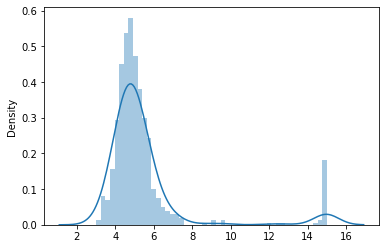

In [33]:
sns.distplot(spectral_diffs)

<AxesSubplot:ylabel='Density'>

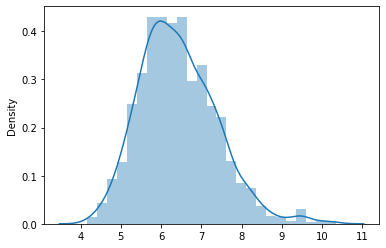

In [27]:
sns.distplot(spectral_diffs)

<AxesSubplot:ylabel='Density'>

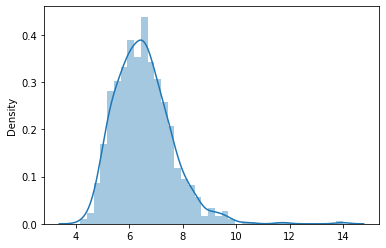

In [22]:
sns.distplot(spectral_diffs)

In [30]:
def sym(A):
    return 0.5*(A+A.T)

In [31]:
Asleep = A.copy()


In [48]:
lpt = latent_position_test(sym(Asleep), sym(Amats[...,0]), n_bootstraps=100, 
                           n_components=None)
print('p = {}'.format(lpt[0]))

ValueError: Input matrices do not have matching dimensions

In [63]:
lpt = latent_distribution_test(Asleep, Amats[...,0], test='hsic',
                               n_bootstraps=500, n_components=2, 
                               workers=-1)
print('p = {}'.format(lpt[0]))

p = 0.002


<AxesSubplot:>

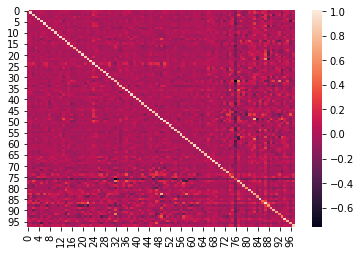

In [14]:
# compute closest symmetric matrix
Asym = 0.5 * (A + A.T)

sns.heatmap(Asym)

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

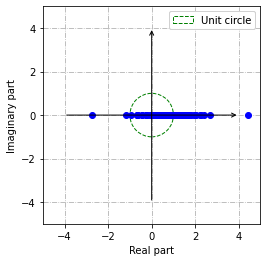

In [15]:
lds = DiscreteLinearSystem(Asym)
lds.plot_eigs()

In [18]:
# Transform in directed case
# ase = AdjacencySpectralEmbed(algorithm='randomized', 
# #                             n_components=2
#                             )
# Xhat, Yhat = ase.fit_transform(A)

lse = LaplacianSpectralEmbed(algorithm='full')
Xhat, Yhat = lse.fit_transform(Asym)

# Plot both embeddings
pairplot(Xhat, title='SBM adjacency spectral embedding "out"')
_ = pairplot(Yhat, title='SBM adjacency spectral embedding "in"')

ValueError: array must not contain infs or NaNs

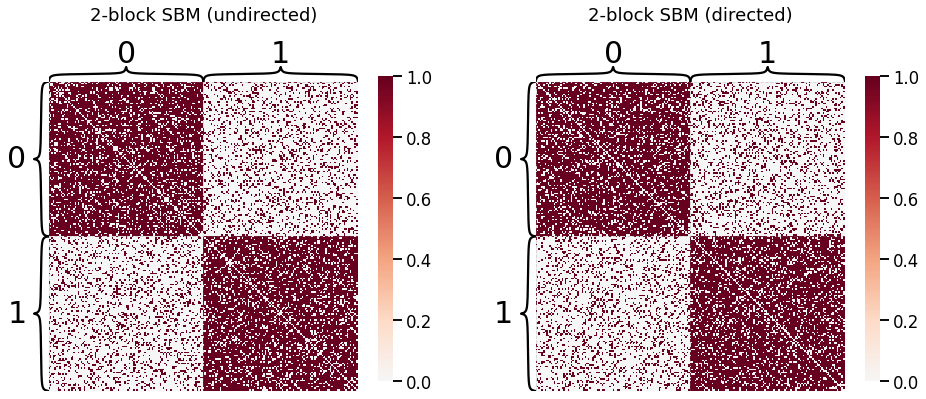

In [22]:
# Define parameters
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

# Plot both SBMs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
heatmap(undirected_sbm, title='2-block SBM (undirected)', inner_hier_labels=labels_sbm, ax=axes[0])
heatmap(directed_sbm, title='2-block SBM (directed)', inner_hier_labels=labels_sbm, ax=axes[1]);

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

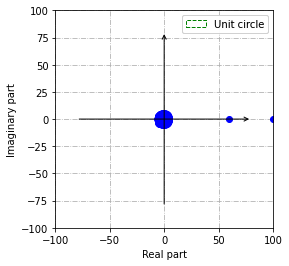

In [26]:
lds = DiscreteLinearSystem(directed_sbm)
lds.plot_eigs()